# Exploring the data from the Pedestrian Collisions in Calgary
This notebook is to explore the data, and to try to find an idea for the kind of angle we want to take for the project.

## Setup
Setting up the notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
raw_data = pd.read_csv("data/Traffic_Incidents_Pedestrians.csv")

In [3]:
raw_data.head()

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point
0,51 Street and 32 Avenue SW,There is an incident involving a pedestrian- E...,2025/09/19 04:27:58 PM,2025/09/19 05:41:22 PM,SW,-114.160961,51.025437,1,2025-09-19T16:27:5851.02543656008146-114.16096...,POINT (-114.16096074903503 51.02543656008146)
1,Charleswood Drive and Cherokee Drive NW,There is an incident involving a pedestrian- E...,2025/09/19 07:57:28 AM,2025/09/19 08:17:19 AM,NW,-114.121819,51.085713,1,2025-09-19T07:57:2851.0857131601675-114.121819...,POINT (-114.12181911764277 51.0857131601675)
2,4 Avenue and 68 Street NE,There is an incident involving a pedestrian- E...,2025/09/18 05:13:44 PM,2025/09/18 05:58:30 PM,NE,-113.935036,51.055767,1,2025-09-18T17:13:4451.05576688512121-113.93503...,POINT (-113.93503593583013 51.05576688512121)
3,17 Avenue and 10 Street SW,There is an incident involving a pedestrian- E...,2025/09/18 04:23:16 PM,2025/09/18 04:25:24 PM,SW,-114.087039,51.037813,1,2025-09-18T16:23:1651.03781307213497-114.08703...,POINT (-114.08703931044585 51.03781307213497)
4,Nose Hill Drive and John Laurie Boulevard NW,There is an incident involving a pedestrian- E...,2025/09/16 06:23:19 AM,2025/09/16 06:55:34 AM,NW,-114.194895,51.127420,1,2025-09-16T06:23:1951.127420365497365-114.1948...,POINT (-114.19489513405182 51.127420365497365)


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INCIDENT INFO  2148 non-null   object 
 1   DESCRIPTION    2148 non-null   object 
 2   START_DT       2148 non-null   object 
 3   MODIFIED_DT    1655 non-null   object 
 4   QUADRANT       1655 non-null   object 
 5   Longitude      2148 non-null   float64
 6   Latitude       2148 non-null   float64
 7   Count          2148 non-null   int64  
 8   id             2148 non-null   object 
 9   Point          2148 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 167.9+ KB


In [5]:
raw_data.describe()

,Longitude,Latitude,Count
count,2148.000000,2148.000000,2148.0
mean,-114.053503,51.045420,1.0
std,0.068458,0.058982,0.0
min,-114.252806,50.862955,1.0
25%,-114.088843,51.033287,1.0
50%,-114.064678,51.046346,1.0
75%,-113.985630,51.076316,1.0
max,-113.888660,51.186383,1.0


Ok, admittedly, this data is kind of lackluster. Apart from the geographical information, there does not seem to be a lot to work with here. I can maybe try and find some type of results through this, but I will most likely be moving to another dataset soon.

In [6]:
raw_data['DESCRIPTION'].nunique()

336

Man, what the hell. This means that there are about 330 different types of descriptions for the traffic incidents.

In [7]:
raw_data['DESCRIPTION'].value_counts().head(25)

DESCRIPTION
There is an incident involving a pedestrian.                                                                                  651
There is an incident involving a pedestrian- EMS on site.                                                                     611
There is an incident involving a pedestrian- EMS Dispatched.                                                                  272
There is an incident involving a pedestrian- EMS on site. Blocking the right lane                                              76
There is an incident involving a pedestrian- EMS on site. Blocking the left lane                                               22
There is an incident involving a pedestrian. Blocking the right lane                                                           19
There is an incident involving a pedestrian- EMS on site.  Blocking the right lane                                             19
Incident involving a pedestrian.                                              

Ok, so there is something we can do here. Let's ignore the descriptions that are one-off, and group together all the incidents that are similar. For example, we can group together "Two vehicle incident. Blocking the right lane" and "Two vehicle incident. Blocking the left lane" to just "Two vehicle incident"

## Cleaning up the Data

### Cleaning and Normalizing Pedestrian Incident Descriptions  

The raw `DESCRIPTION` field contains many small variations of pedestrian-related incidents.  
For example:  
- `There is an incident involving a pedestrian- EMS on site.`  
- `There is an incident involving a pedestrian- EMS Dispatched. Blocking the right lane`  
- `There is an incident involving a pedestrian. Blocking the left lane`  

All of these should map into broader, standardized categories to simplify analysis.  

I grouped the data into the following main categories:  
- **Pedestrian incident** (general, no further detail)  
- **Pedestrian incident – EMS dispatched**  
- **Pedestrian incident – EMS on site**  
- **Pedestrian incident – EMS involved** (fallback when EMS is mentioned but not clearly “dispatched” or “on site”)  
- **Pedestrian incident – Blocking lanes**  
- **Pedestrian incident – Road closed**  
- **Other** (for unexpected or rare variations)  

I used a rule-based string matching function to map each raw description to one of these categories.  
Any description not matching one of the defined patterns is grouped under **Other**.  


In [8]:
df = raw_data.copy()

def clean_description(desc):
    if pd.isna(desc):  # handle missing values
        return "Other"
    
    desc = str(desc).lower().strip()

    # Core pedestrian incident
    if "pedestrian" in desc:
        if "ems" in desc:
            if "dispatched" in desc:
                return "Pedestrian incident - EMS dispatched"
            elif "on site" in desc:
                return "Pedestrian incident - EMS on site"
            else:
                return "Pedestrian incident - EMS involved"
        elif "road is closed" in desc:
            return "Pedestrian incident - Road closed"
        elif "blocking" in desc:
            return "Pedestrian incident - Blocking lanes"
        else:
            return "Pedestrian incident"

    # Fallback for anything unusual
    return "Other"

df["DESCRIPTION_CLEAN"] = df["DESCRIPTION"].apply(clean_description)

In [9]:
df.head()

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,DESCRIPTION_CLEAN
0,51 Street and 32 Avenue SW,There is an incident involving a pedestrian- E...,2025/09/19 04:27:58 PM,2025/09/19 05:41:22 PM,SW,-114.160961,51.025437,1,2025-09-19T16:27:5851.02543656008146-114.16096...,POINT (-114.16096074903503 51.02543656008146),Pedestrian incident - EMS dispatched
1,Charleswood Drive and Cherokee Drive NW,There is an incident involving a pedestrian- E...,2025/09/19 07:57:28 AM,2025/09/19 08:17:19 AM,NW,-114.121819,51.085713,1,2025-09-19T07:57:2851.0857131601675-114.121819...,POINT (-114.12181911764277 51.0857131601675),Pedestrian incident - EMS on site
2,4 Avenue and 68 Street NE,There is an incident involving a pedestrian- E...,2025/09/18 05:13:44 PM,2025/09/18 05:58:30 PM,NE,-113.935036,51.055767,1,2025-09-18T17:13:4451.05576688512121-113.93503...,POINT (-113.93503593583013 51.05576688512121),Pedestrian incident - EMS on site
3,17 Avenue and 10 Street SW,There is an incident involving a pedestrian- E...,2025/09/18 04:23:16 PM,2025/09/18 04:25:24 PM,SW,-114.087039,51.037813,1,2025-09-18T16:23:1651.03781307213497-114.08703...,POINT (-114.08703931044585 51.03781307213497),Pedestrian incident - EMS on site
4,Nose Hill Drive and John Laurie Boulevard NW,There is an incident involving a pedestrian- E...,2025/09/16 06:23:19 AM,2025/09/16 06:55:34 AM,NW,-114.194895,51.127420,1,2025-09-16T06:23:1951.127420365497365-114.1948...,POINT (-114.19489513405182 51.127420365497365),Pedestrian incident - EMS on site


In [10]:
df['DESCRIPTION_CLEAN'].value_counts()

DESCRIPTION_CLEAN
Pedestrian incident - EMS on site       977
Pedestrian incident                     715
Pedestrian incident - EMS dispatched    338
Pedestrian incident - Blocking lanes     91
Pedestrian incident - Road closed        27
Name: count, dtype: int64

Woah, now we can actually do something! YAY!

In [11]:
df.isna().sum()

INCIDENT INFO          0
DESCRIPTION            0
START_DT               0
MODIFIED_DT          493
QUADRANT             493
Longitude              0
Latitude               0
Count                  0
id                     0
Point                  0
DESCRIPTION_CLEAN      0
dtype: int64

A lot of missing values in both MODIFIED_DT and QUADRANT. We won't need modified date, we can just use start date. But quadrant is important, so maybe we can derive it with longitude and latitude?

In [12]:
df = df.drop('MODIFIED_DT', axis=1)
df = df.drop('DESCRIPTION', axis=1)

In [13]:
df.head()

,INCIDENT INFO,START_DT,QUADRANT,Longitude,Latitude,Count,id,Point,DESCRIPTION_CLEAN
0,51 Street and 32 Avenue SW,2025/09/19 04:27:58 PM,SW,-114.160961,51.025437,1,2025-09-19T16:27:5851.02543656008146-114.16096...,POINT (-114.16096074903503 51.02543656008146),Pedestrian incident - EMS dispatched
1,Charleswood Drive and Cherokee Drive NW,2025/09/19 07:57:28 AM,NW,-114.121819,51.085713,1,2025-09-19T07:57:2851.0857131601675-114.121819...,POINT (-114.12181911764277 51.0857131601675),Pedestrian incident - EMS on site
2,4 Avenue and 68 Street NE,2025/09/18 05:13:44 PM,NE,-113.935036,51.055767,1,2025-09-18T17:13:4451.05576688512121-113.93503...,POINT (-113.93503593583013 51.05576688512121),Pedestrian incident - EMS on site
3,17 Avenue and 10 Street SW,2025/09/18 04:23:16 PM,SW,-114.087039,51.037813,1,2025-09-18T16:23:1651.03781307213497-114.08703...,POINT (-114.08703931044585 51.03781307213497),Pedestrian incident - EMS on site
4,Nose Hill Drive and John Laurie Boulevard NW,2025/09/16 06:23:19 AM,NW,-114.194895,51.127420,1,2025-09-16T06:23:1951.127420365497365-114.1948...,POINT (-114.19489513405182 51.127420365497365),Pedestrian incident - EMS on site


In [14]:
df['Count'].nunique()

1

In [15]:
df = df.drop('Count', axis=1)
df = df.drop('id', axis=1)
df = df.drop('Point', axis=1)

In [16]:
df["START_DT"] = pd.to_datetime(df["START_DT"])

/var/folders/qw/y3ys43gs7cdblx18lvtrz8r40000gn/T/ipykernel_4062/2550944546.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["START_DT"] = pd.to_datetime(df["START_DT"])


In [17]:
df.head()

,INCIDENT INFO,START_DT,QUADRANT,Longitude,Latitude,DESCRIPTION_CLEAN
0,51 Street and 32 Avenue SW,2025-09-19 16:27:58,SW,-114.160961,51.025437,Pedestrian incident - EMS dispatched
1,Charleswood Drive and Cherokee Drive NW,2025-09-19 07:57:28,NW,-114.121819,51.085713,Pedestrian incident - EMS on site
2,4 Avenue and 68 Street NE,2025-09-18 17:13:44,NE,-113.935036,51.055767,Pedestrian incident - EMS on site
3,17 Avenue and 10 Street SW,2025-09-18 16:23:16,SW,-114.087039,51.037813,Pedestrian incident - EMS on site
4,Nose Hill Drive and John Laurie Boulevard NW,2025-09-16 06:23:19,NW,-114.194895,51.127420,Pedestrian incident - EMS on site


In [18]:
def assign_quadrant(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return None
    if lat > 51.045:  # North
        if lon > -114.071:
            return "NE"
        else:
            return "NW"
    else:  # South
        if lon > -114.071:
            return "SE"
        else:
            return "SW"

# Apply to the dataframe
df["QUADRANT"] = df.apply(
    lambda row: assign_quadrant(row["Latitude"], row["Longitude"]), axis=1
)


In [19]:
df.isna().sum()

INCIDENT INFO        0
START_DT             0
QUADRANT             0
Longitude            0
Latitude             0
DESCRIPTION_CLEAN    0
dtype: int64

## EDA

In [20]:
df['INCIDENT INFO'].nunique()

1950

In [21]:
df['INCIDENT INFO'].value_counts().head(25)

INCIDENT INFO
1000 Memorial Drive NW                                    5
1 Street and 15 Avenue SE                                 4
 17 Avenue and 5 Street SW                                4
 17 Avenue and 36 Street SE                               4
 Westbound Memorial Drive at and Marlborough Way NE       3
16 Avenue and 14 Street SW                                3
94 Avenue and Bonaventure Drive SE                        3
 3 Street south of 5 Avenue SE                            3
 Dalhousie Drive and Dalton Drive NW                      3
10 Avenue and 4 Street SW                                 3
 Southbound Stoney Trail approaching McKnight Blvd NE     3
44 Street and 8 Avenue SE                                 3
 Northbound Deerfoot Trail after Peigan Trail SE          3
Heritage Drive and Fairview Drive SE                      3
 6 Avenue and 3 Street SE                                 3
Southbound Deerfoot Trail and 11 Street SE                3
1 Street and 9 Avenue SW  

Use the above data to mix and match with geographical mapping to see which type of intersections lead to more accidents.

### Finding Trends in Time
Lets split up the seasons to spring, summer, fall, winter.

In [22]:
def categorize_seasons(date):
    if pd.isna(date):
        return None
    month = date.month
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return "Winter"

df["SEASON"] = df["START_DT"].apply(categorize_seasons)

In [23]:
df["SEASON"].value_counts()

SEASON
Fall      687
Summer    530
Winter    522
Spring    409
Name: count, dtype: int64

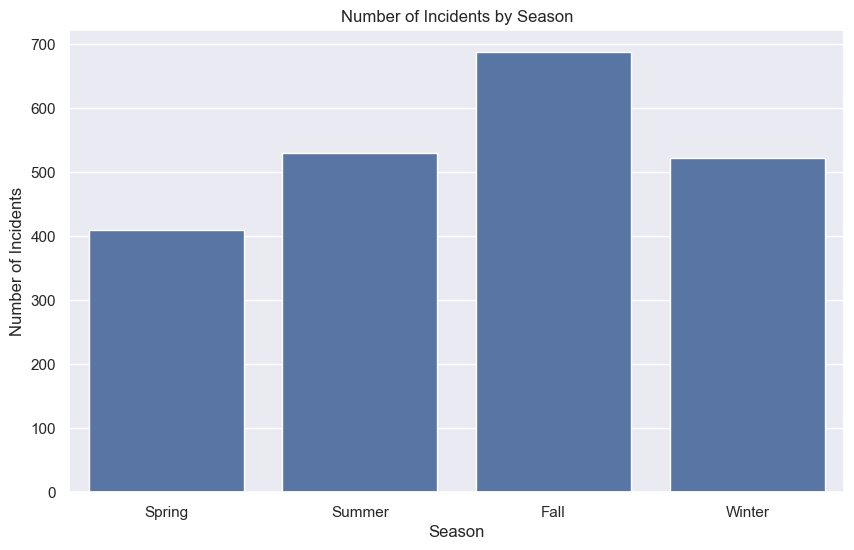

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="SEASON", order=["Spring", "Summer", "Fall", "Winter"])
plt.title("Number of Incidents by Season")
plt.xlabel("Season")
plt.ylabel("Number of Incidents")
plt.show()

Definite increase in accidents during Fall and Summer, with the most accidents happening in Summer.

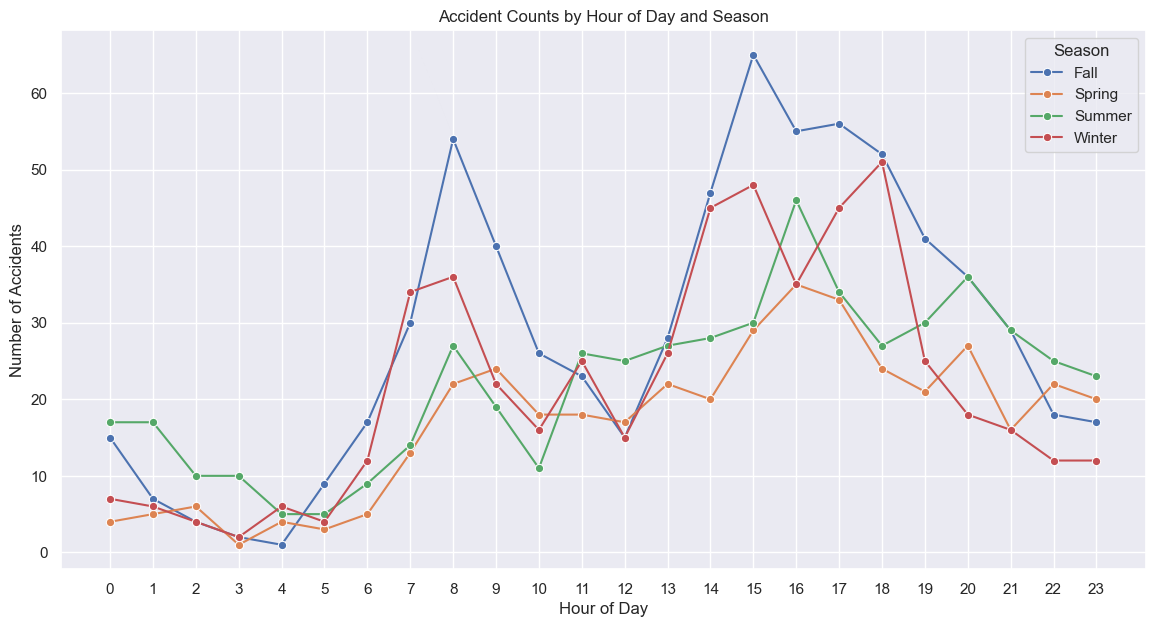

In [25]:
# Extract hour from START_DT
df['HOUR'] = df['START_DT'].dt.hour

# Group by season and hour, count incidents
season_hour_counts = df.groupby(['SEASON', 'HOUR']).size().reset_index(name='INCIDENT_COUNT')

plt.figure(figsize=(14, 7))
sns.lineplot(data=season_hour_counts, x='HOUR', y='INCIDENT_COUNT', hue='SEASON', marker='o')
plt.title('Accident Counts by Hour of Day and Season')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Season')
plt.xticks(range(0, 24))
plt.show()

Highest time for accident is either at 8am or 3pm, majority accidents happening between those periods.

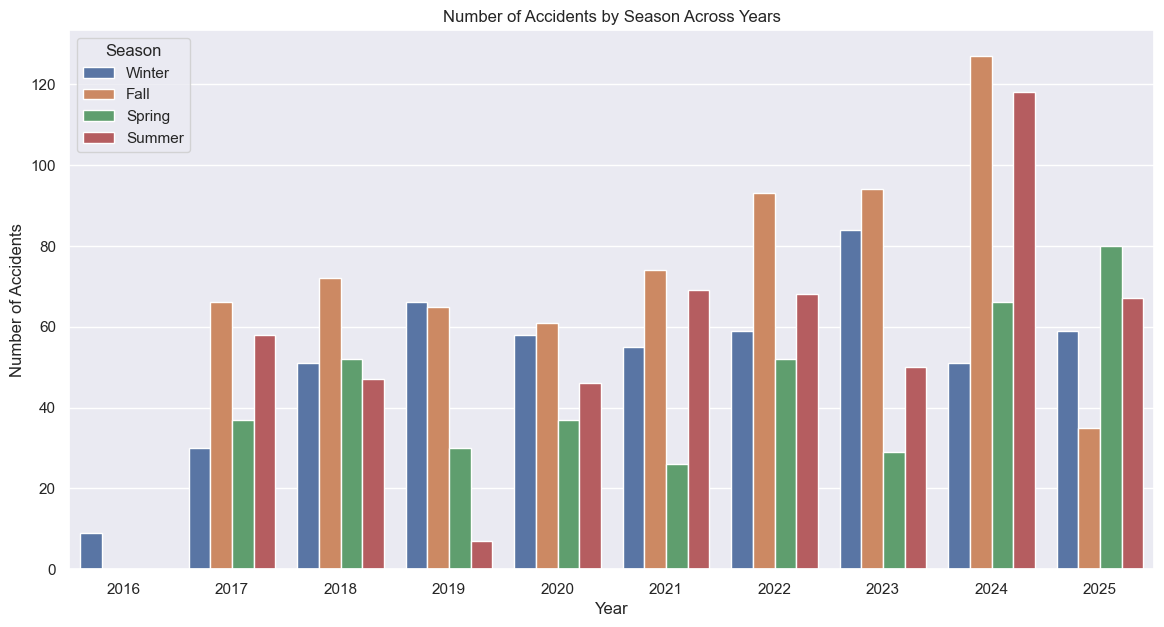

In [26]:
# Extract year from START_DT
df['YEAR'] = df['START_DT'].dt.year

# Group by YEAR and SEASON, count incidents
season_year_counts = df.groupby(['YEAR', 'SEASON']).size().reset_index(name='INCIDENT_COUNT')

plt.figure(figsize=(14, 7))
sns.barplot(data=season_year_counts, x='YEAR', y='INCIDENT_COUNT', hue='SEASON')
plt.title('Number of Accidents by Season Across Years')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend(title='Season')
plt.show()

WEEKPART
Weekday    1657
Weekend     491
Name: count, dtype: int64


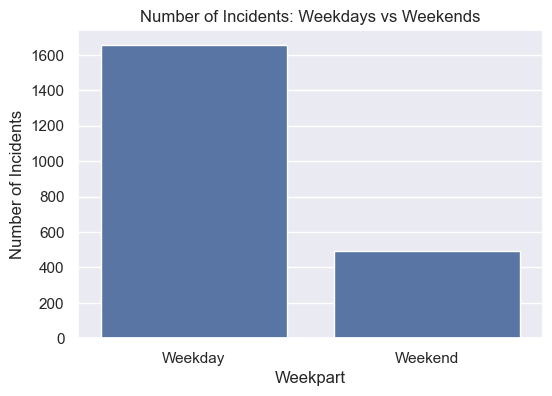

In [27]:
# Add a column for day of week (0=Monday, ..., 6=Sunday)
df['DAY_OF_WEEK'] = df['START_DT'].dt.dayofweek

# Create a new column to indicate Weekday or Weekend
df['WEEKPART'] = df['DAY_OF_WEEK'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Count incidents by Weekday/Weekend
weekpart_counts = df['WEEKPART'].value_counts()

print(weekpart_counts)

# Plot incidents by Weekday vs Weekend
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='WEEKPART', order=['Weekday', 'Weekend'])
plt.title('Number of Incidents: Weekdays vs Weekends')
plt.xlabel('Weekpart')
plt.ylabel('Number of Incidents')
plt.show()

### Finding Trends in Type of Accident
Let's see what types of accidents happen the most, and what to watch out for.

Here are all the different type of accidents there are:
- **Pedestrian incident** (general, no further detail)  
- **Pedestrian incident – EMS dispatched**  
- **Pedestrian incident – EMS on site**  
- **Pedestrian incident – EMS involved** (fallback when EMS is mentioned but not clearly “dispatched” or “on site”)  
- **Pedestrian incident – Blocking lanes**  
- **Pedestrian incident – Road closed**  
- **Other** (for unexpected or rare variations)  

Let's first just see the count of each of these:

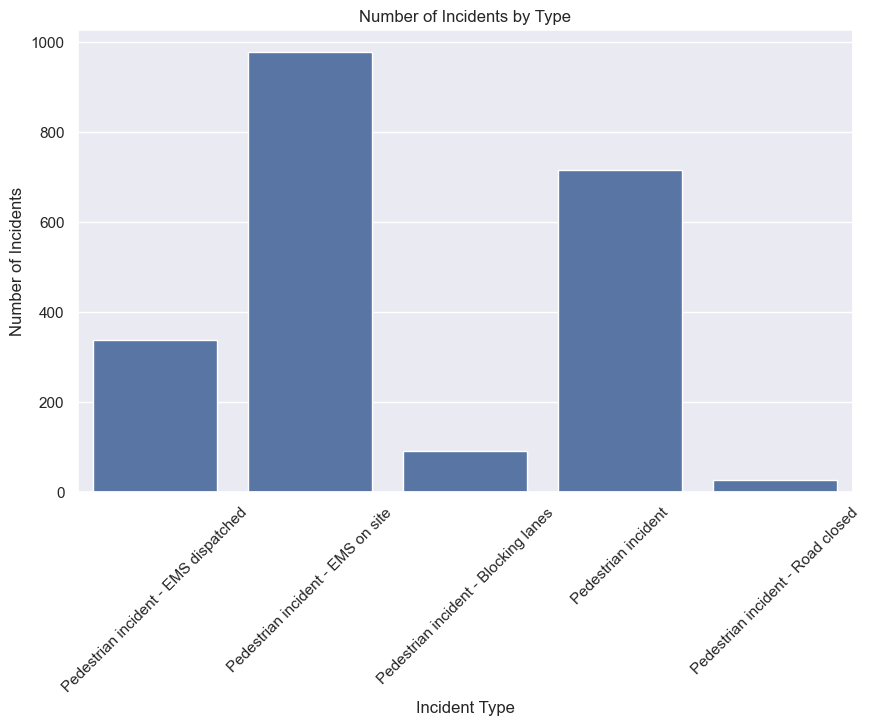

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="DESCRIPTION_CLEAN")
plt.title("Number of Incidents by Type")
plt.xlabel("Incident Type")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.show()

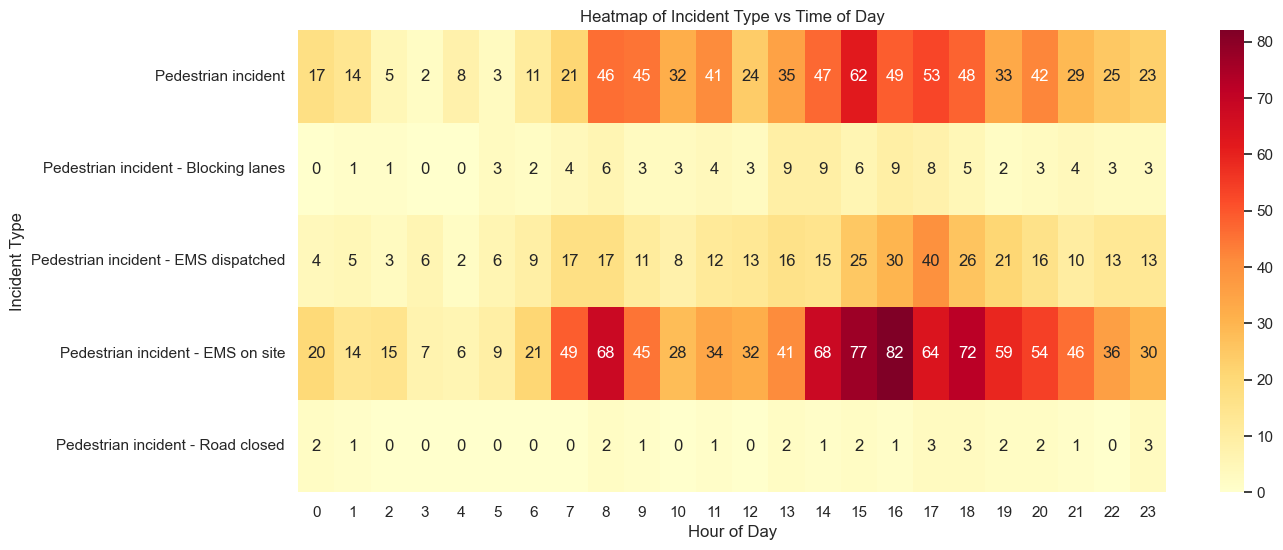

In [29]:
# Create a pivot table: rows are incident types, columns are hours, values are counts
heatmap_data = df.pivot_table(
    index="DESCRIPTION_CLEAN",
    columns="HOUR",
    values="INCIDENT INFO",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Heatmap of Incident Type vs Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Incident Type")
plt.show()

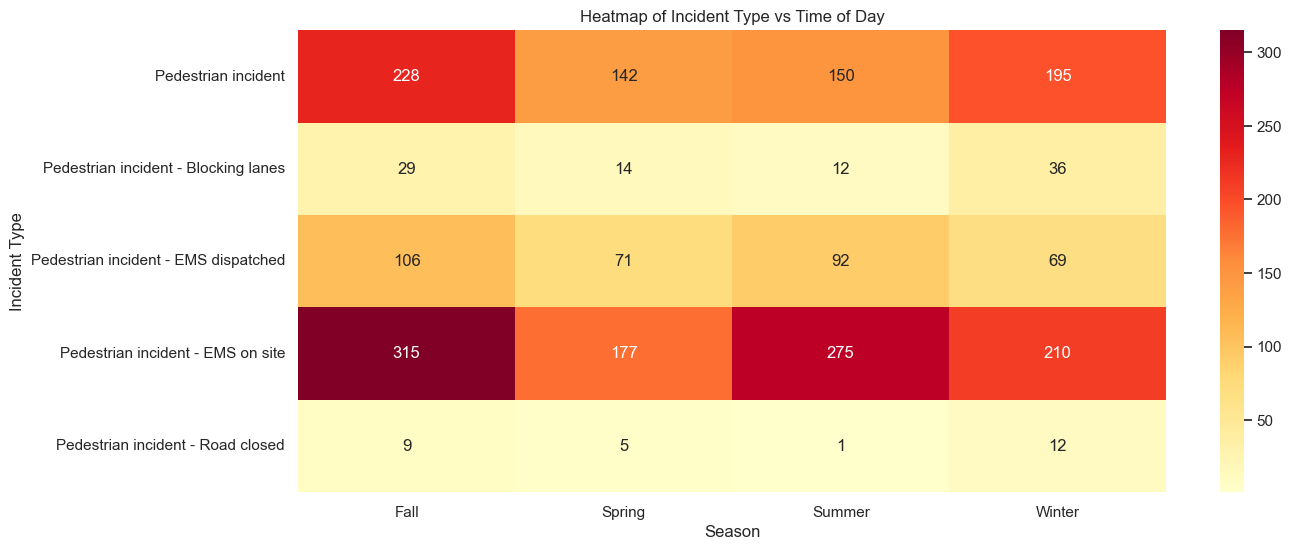

In [30]:
heatmap_data = df.pivot_table(
    index="DESCRIPTION_CLEAN",
    columns="SEASON",
    values="INCIDENT INFO",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Heatmap of Incident Type vs Time of Day")
plt.xlabel("Season")
plt.ylabel("Incident Type")
plt.show()

Not really a lot of insights from this dataset on the type of accident, it may be time to look at the medical records to look at that